In [1]:
import numpy as np
import os
import csv
import runtests
import makegraphs
import makegraphs_new
import pandas
from matplotlib import pyplot as plt

# runtests testing

In [2]:
def return_one(startdisk, zfsname, csvfilename, ip, skip_num=0):
    with open(csvfilename) as csvfile:
        reader = csv.reader(csvfile, delimiter=",")
        next(reader)
        for _ in range(skip_num):
            next(reader)
        row = next(reader)
        testname, numberdisks, raidmode, raid0, ashift, compression, recordsize, atime, filesize, benchmark, runtime, blocksizes, iodepths, numjobs = row
        print (testname, numberdisks, raidmode, raid0, ashift, compression, recordsize, atime, filesize, benchmark, runtime, blocksizes, iodepths, numjobs)
        print ("++++++++++++++++++++++++++++")
        print (testname)
        print ("++++++++++++++++++++++++++++")
        numberdisks = int(numberdisks)
        raidmode = int(raidmode)
        raid0 = int(raid0)
        return runtests.make_commands(startdisk, numberdisks, zfsname, raidmode, raid0, ashift, compression, recordsize, atime, testname, ip, filesize, benchmark, runtime, blocksizes, iodepths, numjobs)

In [3]:
cmds = return_one("c", "tank", "config.csv", "192.168.169.207", skip_num=2)

z2_one_8_1m 8 6 0 12  1m off 10000g FALSE 50 64m 1 2 1 4 8
++++++++++++++++++++++++++++
z2_one_8_1m
++++++++++++++++++++++++++++


fio --directory=/tank --direct=1 --bs=32m --ioengine=psync --iodepth=1 --numjobs=32 --filesize=100g --group_reporting --name=throughput-test --eta-newline=1 --rw=write >> test_zfs_write.txt
fio --directory=/tank --direct=1 --bs=32m --ioengine=psync --iodepth=1 --numjobs=32 --filesize=100g --group_reporting --name=throughput-test --eta-newline=1 --rw=read --readonly >> test_zfs_read.txt

In [4]:
for cmd in cmds:
    print(cmd)

mkdir tests
mkdir z2_one_8_1m
mkdir z2_one_8_1m/outputs
mkdir z2_one_8_1m/outputs/zfs
mkdir z2_one_8_1m/outputs/lustre
mkdir z2_one_8_1m/bandwidth_logs
mkdir z2_one_8_1m/bandwidth_logs/zfs
mkdir z2_one_8_1m/bandwidth_logs/lustre
echo -------------------------------
echo make zfs
echo -------------------------------
zpool create tank -f -o ashift=12 raidz2 sdc sdd sde sdf sdg sdh sdi sdj
zfs set recordsize=1m atime=off tank
echo -------------------------------
echo test zfs
echo -------------------------------
fio --direct=1 --group_reporting --name=throughput-test --eta-newline=1 --time_based --bandwidth-log --bs=64m --ioengine=psync --iodepth=1 --numjobs=1 --runtime=50 --filename=/tank/throughput-test --rw=write --output=z2_one_8_1m/outputs/zfs/1-1-64m_write.txt --filesize=10000g
mv agg-write_bw.log z2_one_8_1m/bandwidth_logs/zfs/1-1-64m_write.log
rm -f agg-*
fio --direct=1 --group_reporting --name=throughput-test --eta-newline=1 --time_based --bandwidth-log --bs=64m --ioengine=psync 

fio --directory=/tank --direct=1 --rw=write --bs=32m --ioengine=libaio --iodepth=64 --filesize=30g --numjobs=2 --group_reporting --name=throughput-test --eta-newline=1

./bench_fio --target /tank --type directory -o onedisk_fioplot -b 16m 32m 64m -m write --loops 1 --iodepth 1 2 --numjobs 1 2 --ss iops:10% --ss-ramp 10 --ss-dur 30 --runtime 300 --size 20g

./fio_plot/fio_plot -T "title" -r write -g -t bw -d 1 2 -n 1 2 -i benchmark_script/onedisk_fioplot/tank/32m/

./fio-plot/fio_plot/fio_plot -T "bandwidth of write on lustre raidz2(8 drives) given iodepth and numjobs 32m" -i z2_one_8_single_lustre/lustre/16m -g -r write -t bw -d 1 2 4 -n 1 4 8
./fio-plot/fio_plot/fio_plot -T "bandwidth of write on zfs 60 (2x8 drives) given iodepth and numjobs 64m" -i z2_one_8_single_zfs/tank/64m -g -r write -t bw -d 1 2 4 -n 1 4 8
./fio-plot/fio_plot/fio_plot -T "bandwidth of read on zfs raidz2(8 drives) given iodepth and numjobs m" -i z2_one_8_single_zfs/tank/16m -g -r read -t bw -d 1 2 4 -n 1 4 8


# makegraphs testing

In [5]:
# skip_num = 11
# # TODO: stop to param
# # set stop to 0 if you don't need it
# stop = 0
# cmds = makegraphs.make_commands("config.csv", skip_num)

In [6]:
def make_commands_graph_one(csvfilename, skip_num):
    cmds = []
    with open(csvfilename) as csvfile:
        reader = csv.reader(csvfile, delimiter=",")
        next(reader)
        for _ in range(skip_num):
            next(reader)
        stop_counter = 0
        row = next(reader)
        testname, numberdisks, raidmode, raid0, ashift, compression, recordsize, atime, filesize, benchmark, runtime, blocksizes, iodepths, numjobs = row
        rws = ["read", "write"]
        fss = ["zfs", "lustre"]
        blocksizes = blocksizes.split()
        # print (blocksizes)
        graphdir = "graph_" + testname
        cmds.append ("mkdir " + graphdir)
        for bs in blocksizes:
            blockdir = graphdir +"/"+bs
            cmds.append ("mkdir "+ blockdir)
            for fs in fss:
                for rw in rws:
                    plot_cmd, title = makegraphs.make_plot_cmd (rw, fs, bs, iodepths, numjobs, testname, recordsize)
                    title = title.replace(" ", "-")
                    cmds.append (plot_cmd)
                    cmds.append ("mv " + title + '* ' + blockdir)
    return cmds

In [7]:
%matplotlib inline

In [8]:
cmds = make_commands_graph_one ("config.csv", skip_num=0)
for cmd in cmds:
    print (cmd)

mkdir graph_onedisk_128k
mkdir graph_onedisk_128k/64m
./fio-plot/fio_plot/fio_plot -T "bandwidth of read on zfs onedisk_128k 64m" -i onedisk_128k/lustre/64m -g -r read -t bw -d 1 2 -n 1 4 8 --disable-fio-version
mv bandwidth-of-read-on-zfs-onedisk_128k-64m* graph_onedisk_128k/64m
./fio-plot/fio_plot/fio_plot -T "bandwidth of write on zfs onedisk_128k 64m" -i onedisk_128k/lustre/64m -g -r write -t bw -d 1 2 -n 1 4 8 --disable-fio-version
mv bandwidth-of-write-on-zfs-onedisk_128k-64m* graph_onedisk_128k/64m
./fio-plot/fio_plot/fio_plot -T "bandwidth of read on lustre onedisk_128k 64m" -i onedisk_128k/tank/64m -g -r read -t bw -d 1 2 -n 1 4 8 --disable-fio-version
mv bandwidth-of-read-on-lustre-onedisk_128k-64m* graph_onedisk_128k/64m
./fio-plot/fio_plot/fio_plot -T "bandwidth of write on lustre onedisk_128k 64m" -i onedisk_128k/tank/64m -g -r write -t bw -d 1 2 -n 1 4 8 --disable-fio-version
mv bandwidth-of-write-on-lustre-onedisk_128k-64m* graph_onedisk_128k/64m


onedisk_128k


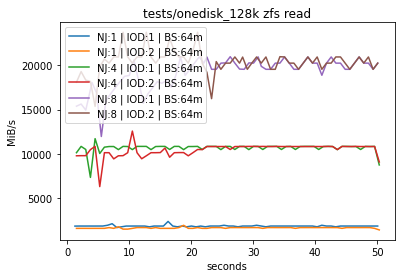

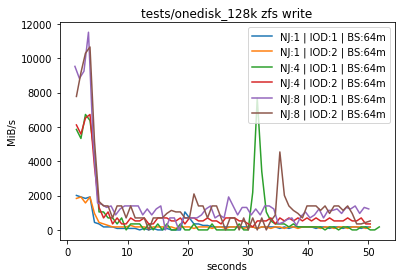

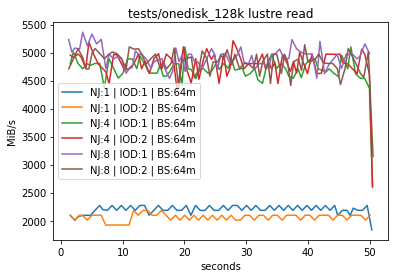

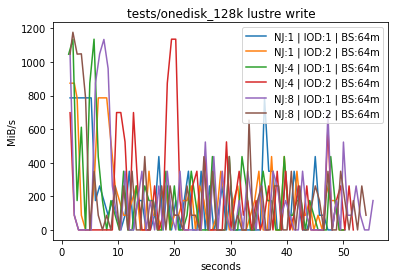

In [9]:
plt.close()
figs, outputs = makegraphs_new.gen_plots("config.csv", 0, 1 , save=False, show_output=True, gen_plt=True)


In [14]:
output_one_test = outputs[0]
for output_quarter in output_one_test:
    print ('-------------------------')
    for output in output_quarter:
        print (output)

-------------------------
NJ:1 | IOD:1 | BS:64m   READ: bw=1791MiB/s (1878MB/s), 1791MiB/s-1791MiB/s (1878MB/s-1878MB/s), io=87.5GiB (93.0GB), run=50026-50026msec

NJ:1 | IOD:2 | BS:64m   READ: bw=1588MiB/s (1666MB/s), 1588MiB/s-1588MiB/s (1666MB/s-1666MB/s), io=77.6GiB (83.3GB), run=50001-50001msec

NJ:4 | IOD:1 | BS:64m   READ: bw=10.2GiB/s (10.9GB/s), 10.2GiB/s-10.2GiB/s (10.9GB/s-10.9GB/s), io=508GiB (546GB), run=50008-50008msec

NJ:4 | IOD:2 | BS:64m   READ: bw=9.98GiB/s (10.7GB/s), 9.98GiB/s-9.98GiB/s (10.7GB/s-10.7GB/s), io=499GiB (536GB), run=50020-50020msec

NJ:8 | IOD:1 | BS:64m   READ: bw=18.2GiB/s (19.5GB/s), 18.2GiB/s-18.2GiB/s (19.5GB/s-19.5GB/s), io=911GiB (978GB), run=50012-50012msec

NJ:8 | IOD:2 | BS:64m   READ: bw=19.4GiB/s (20.8GB/s), 19.4GiB/s-19.4GiB/s (20.8GB/s-20.8GB/s), io=971GiB (1042GB), run=50023-50023msec

-------------------------
NJ:1 | IOD:1 | BS:64m  WRITE: bw=287MiB/s (301MB/s), 287MiB/s-287MiB/s (301MB/s-301MB/s), io=14.1GiB (15.2GB), run=50423-50423m

In [11]:
a

NameError: name 'a' is not defined